In [1]:
!apt-get install tor
!service tor start
!pip install pyupbit
!pip install pybit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  logrotate tor-geoipdb torsocks
Suggested packages:
  bsd-mailx | mailx mixmaster torbrowser-launcher socat apparmor-utils nyx obfs4proxy
The following NEW packages will be installed:
  logrotate tor tor-geoipdb torsocks
0 upgraded, 4 newly installed, 0 to remove and 18 not upgraded.
Need to get 2,884 kB of archives.
After this operation, 15.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 logrotate amd64 3.19.0-1ubuntu1.1 [54.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tor amd64 0.4.6.10-1 [1,665 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 torsocks amd64 2.3.0-3 [62.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tor-geoipdb all 0.4.6.10-1 [1,103 kB]
Fetched 2,884 kB in 3s (1,108 kB/s)
Selecting previously unselected pa

In [3]:
import socket
import socks
import requests

socks.set_default_proxy(socks.SOCKS5, "127.0.0.1", 9050)
socket.socket = socks.socksocket
print(requests.get('https://httpbin.org/ip').text)

{
  "origin": "185.220.101.21"
}



In [2]:
import sqlite3
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
import time
import pyupbit
from pybit.unified_trading import HTTP
import yfinance as yf
import ipywidgets as widgets
from IPython.display import display

In [53]:
session = HTTP(testnet=False)
BYBIT_BASE_URL = "https://api.bybit.com"
UPBIT_BASE_URL = "https://api.upbit.com/v1"
RATE_LIMIT_DELAY = 0.1

def fetch_bybit_symbols():
    """
    Bybit에서 USDT 마켓의 거래 가능한 심볼을 가져온다.
    """
    endpoint = "/v5/market/instruments-info"
    url = f"{BYBIT_BASE_URL}{endpoint}"
    params = {"category": "linear"}

    try:
        response = requests.get(url, params=params)
        time.sleep(RATE_LIMIT_DELAY)

        if response.status_code == 200:
            data = response.json()
            if data.get("retCode") == 0:
                return [item['symbol'] for item in data['result']['list']]
            else:
                raise Exception(f"Bybit API Error: {data.get('retMsg')}")
        else:
            raise Exception(f"Bybit HTTP Error: {response.status_code}, {response.text}")

    except requests.exceptions.RequestException as e:
        raise Exception(f"Bybit API 요청 오류: {e}")

def fetch_upbit_symbols():
    """
    Upbit에서 KRW 마켓의 거래 가능한 심볼을 가져온다.
    """
    url = f"{UPBIT_BASE_URL}/market/all"

    try:
        response = requests.get(url)
        time.sleep(RATE_LIMIT_DELAY)

        if response.status_code == 200:
            data = response.json()
            return {item['market']: item['korean_name'] for item in data if item['market'].startswith("KRW-")}
        else:
            raise Exception(f"Upbit HTTP Error: {response.status_code}, {response.text}")

    except requests.exceptions.RequestException as e:
        raise Exception(f"Upbit API 요청 오류: {e}")

def get_common_symbols():
    """
    Bybit과 Upbit에서 공통으로 거래 가능한 심볼을 찾아 반환한다.
    """
    bybit_symbols = fetch_bybit_symbols()
    upbit_markets = fetch_upbit_symbols()

    common_symbols = [
        symbol.replace("USDT", "") for symbol in bybit_symbols
        if symbol.endswith("USDT") and f"KRW-{symbol.replace('USDT', '')}" in upbit_markets
    ]

    return common_symbols

import sqlite3

def fetch_and_save_common_symbols(db_name="derivatives.db"):
    common_symbols = get_common_symbols()

    if common_symbols:
        print(f"Common Symbols: {common_symbols}")


        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()


        cursor.execute('''
            CREATE TABLE IF NOT EXISTS symbols (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                symbol TEXT UNIQUE
            )
        ''')


        cursor.executemany("INSERT OR IGNORE INTO symbols (symbol) VALUES (?)",
                           [(symbol,) for symbol in common_symbols])


        conn.commit()
        conn.close()

        print(f"{len(common_symbols)} symbols saved to {db_name}")
    else:
        print("No common symbols found.")

def calculate_time_period(day):
    end_time = datetime.now(timezone.utc)
    start_time = end_time - timedelta(days=day)
    start_ms = int(start_time.timestamp() * 1000)
    end_ms = int(end_time.timestamp() * 1000)
    return start_ms, end_ms , start_time, end_time

def fetch_krw_usd(interval, day, max_retries=5, retry_delay=5):
    start_ms, end_ms, start_time, end_time = calculate_time_period(day)
    start_time = end_time - timedelta(days=5)
    all_data = pd.DataFrame()


    for i in range(day//5+1):
        retries = 0
        while retries < max_retries:
            try:
                data = yf.download('KRW=X', interval=f"{interval}m", start=start_time, end=end_time)
                if not data.empty:
                    data = data[['Close']].rename(columns={"Close": "KRW_USD"})


                    all_data = pd.concat([all_data, data])
                break
            except Exception as e:
                print(f"Error fetching data for KRW/USD: {e}")
                retries += 1
                if retries < max_retries:
                    print(f"Retrying in {retry_delay} seconds...")
                    time.sleep(retry_delay)
                else:
                    print(f"Max retries reached for KRW/USD. Skipping this request.")
                    break

        end_time = start_time
        start_time = end_time - timedelta(days=5)

    all_data = all_data.ffill()

    return all_data


def fetch_krw_usdt(interval, day, max_retries=5, retry_delay=5):
    start_ms, end_ms, start_time, end_time = calculate_time_period(day)
    all_data = pd.DataFrame()

    retries = 0
    while retries < max_retries:
        try:
            df = pyupbit.get_ohlcv(ticker=f"KRW-USDT", interval=f"minute{interval}", count=1440*day//interval, to=end_time, period=0.1)
            if df is None or df.empty:
                print(f"Upbit 데이터 없음: USDT")
                break

            df.index = df.index.tz_localize("Asia/Seoul").tz_convert("UTC")
            df = df[["close"]].rename(columns={"close": f"KRW-USDT"})
            df.index.name = 'timestamp'

            all_data = df
            break
        except Exception as e:
            print(f"Error fetching data for USDT: {e}")
            retries += 1
            if retries < max_retries:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Max retries reached for USDT. Skipping this request.")
                break

    if all_data.empty:
        print(f"Upbit USDT 데이터가 반환되지 않았습니다: USDT")

    all_data = all_data.ffill()

    return all_data

def fetch_upbit(symbol, interval, day, max_retries=5, retry_delay=5):
    start_ms, end_ms, start_time, end_time = calculate_time_period(day)
    all_data = pd.DataFrame()

    retries = 0
    while retries < max_retries:
        try:
            df = pyupbit.get_ohlcv(ticker=f"KRW-{symbol}", interval=f"minute{interval}", count=1440*day //interval, to=end_time, period=0.1)
            if df is None or df.empty:
                print(f"Upbit 데이터 없음: {symbol}")
                break

            df.index = df.index.tz_localize("Asia/Seoul").tz_convert("UTC")
            df = df[["close"]].rename(columns={"close": f"KRW-{symbol}"})
            df.index.name = 'timestamp'

            all_data = df
            break
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            retries += 1
            if retries < max_retries:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Max retries reached for {symbol}. Skipping this request.")
                break

    if all_data.empty:
        print(f"Upbit 데이터가 반환되지 않았습니다: {symbol}")

    all_data = all_data.ffill()

    return all_data

def fetch_bybit(symbol, interval, day, max_retries=5, retry_delay=5):
    start_ms, end_ms, start_time, end_time = calculate_time_period(day)
    all_data = pd.DataFrame()
    all_closes = []

    retries = 0
    while retries < max_retries:
        try:
            response = session.get_kline(
                category="linear",
                symbol=f"{symbol}USDT",
                interval=str(interval),
                start=start_ms,
                end=end_ms,
                limit=1000
            )

            result_list = response['result'].get('list', [])
            if not result_list:
                print(f"No Data: {symbol}")
                break

            for data in result_list:
                all_closes.append([data[0], data[4]])

            all_data = pd.DataFrame(all_closes, columns=["timestamp", symbol])
            all_data["timestamp"] = pd.to_datetime(all_data["timestamp"].astype(int), unit='ms', utc=True)
            all_data.set_index("timestamp", inplace=True)
            all_data = all_data.rename(columns={symbol: f"{symbol[:-4]}"})
            all_data.index.name = 'timestamp'

            all_data = all_data[~all_data.index.duplicated(keep='last')]
            all_data = all_data.sort_index(ascending=True)
            time.sleep(0.1)

            break

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            retries += 1
            if retries < max_retries:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Max retries reached for {symbol}. Skipping this request.")
                break

    if all_data.empty:
        print(f"No Data: {symbol}")

    all_data = all_data.ffill()

    return all_data

def get_symbols():
    conn = sqlite3.connect('derivatives.db')
    cursor = conn.cursor()

    cursor.execute('SELECT symbol FROM symbols')
    symbols = [row[0] for row in cursor.fetchall()]

    conn.close()
    return symbols

def save_upbit(symbol, upbit_data):
    conn = sqlite3.connect('derivatives.db')
    cursor = conn.cursor()

    table_name = f"'{symbol}_upbit'"
    cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS {table_name} (
        timestamp DATETIME PRIMARY KEY,
        upbit_close REAL
    )''')

    if not upbit_data.empty:
        for timestamp, row in upbit_data.iterrows():
            timestamp = timestamp.to_pydatetime()
            cursor.execute(f'''
            REPLACE INTO {table_name} (timestamp, upbit_close) VALUES (?, ?)
            ''', (timestamp, row['KRW-' + symbol] if 'KRW-' + symbol in row else None))

    conn.commit()
    conn.close()

def save_bybit(symbol, bybit_data):
    conn = sqlite3.connect('derivatives.db')
    cursor = conn.cursor()

    table_name = f"'{symbol}_bybit'"
    cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS {table_name} (
        timestamp DATETIME PRIMARY KEY,
        bybit_close REAL
    )''')

    if not bybit_data.empty:
        for timestamp, row in bybit_data.iterrows():
            timestamp = timestamp.to_pydatetime()
            cursor.execute(f'''
            REPLACE INTO {table_name} (timestamp, bybit_close) VALUES (?, ?)
            ''', (timestamp, row[bybit_data.columns[0]] if bybit_data.columns[0] in row else None))

    conn.commit()
    conn.close()

def save_market_data(symbol, upbit_data, bybit_data):
    """
    Upbit 및 Bybit 데이터를 같은 테이블에 저장하는 함수.
    :param symbol: 저장할 심볼 (예: 'BTC')
    :param upbit_data: Upbit 가격 데이터 (DataFrame)
    :param bybit_data: Bybit 가격 데이터 (DataFrame)
    """
    conn = sqlite3.connect('derivatives.db')
    cursor = conn.cursor()

    table_name = f"'{symbol}'"


    cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS {table_name} (
        timestamp DATETIME PRIMARY KEY,
        upbit_close REAL,
        bybit_close REAL
    )''')


    merged_data = upbit_data.rename(columns={upbit_data.columns[0]: 'upbit_close'}).copy() if not upbit_data.empty else pd.DataFrame()
    if not bybit_data.empty:
        bybit_data = bybit_data.rename(columns={bybit_data.columns[0]: 'bybit_close'}).copy()
        merged_data = merged_data.join(bybit_data, how='outer')


    if not merged_data.empty:
        for timestamp, row in merged_data.iterrows():
            timestamp = timestamp.to_pydatetime()
            upbit_close = row['upbit_close'] if 'upbit_close' in row else None
            bybit_close = row['bybit_close'] if 'bybit_close' in row else None

            cursor.execute(f'''
            REPLACE INTO {table_name} (timestamp, upbit_close, bybit_close) VALUES (?, ?, ?)
            ''', (timestamp, upbit_close, bybit_close))

    conn.commit()
    conn.close()





def save_krw_usd(krw_usd_data, db_path="derivatives.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS KRWUSD (
        timestamp DATETIME PRIMARY KEY,
        krw_usd REAL
    )
    ''')

    if not krw_usd_data.empty:
        krw_usd_data = krw_usd_data.ffill()
        for timestamp, row in krw_usd_data.iterrows():
            timestamp = timestamp.to_pydatetime()
            cursor.execute('''
            REPLACE INTO KRWUSD (timestamp, krw_usd) VALUES (?, ?)
            ''', (timestamp, row['KRW_USD'].values[0]))
        conn.commit()
    conn.close()

def save_krw_usdt(krw_usdt_data, db_path="derivatives.db"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS KRWUSDT (
        timestamp DATETIME PRIMARY KEY,
        krw_usdt REAL
    )
    ''')

    if not krw_usdt_data.empty:
        krw_usdt_data = krw_usdt_data.ffill()
        for timestamp, row in krw_usdt_data.iterrows():
            timestamp = timestamp.to_pydatetime()
            cursor.execute('''
            REPLACE INTO KRWUSDT (timestamp, krw_usdt) VALUES (?, ?)
            ''', (timestamp, row['KRW-USDT']))
        conn.commit()
    conn.close()

def calc_kp():
    conn = sqlite3.connect('derivatives.db')
    cursor = conn.cursor()
    cursor.execute("PRAGMA foreign_keys=OFF")
    cursor.execute('SELECT symbol FROM symbols')
    symbols = cursor.fetchall()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    all_tables = [table[0] for table in cursor.fetchall()]

    for symbol in symbols:
        symbol_name = symbol[0]

        if symbol_name in all_tables:
            cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_timestamp_{symbol_name} ON '{symbol_name}'(timestamp)")
            cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_timestamp_KRWUSD ON 'KRWUSD'(timestamp)")
            cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_timestamp_KRWUSDT ON 'KRWUSDT'(timestamp)")

    try:
        for symbol in symbols:
            symbol_name = symbol[0]

            if symbol_name in all_tables:
                cursor.execute(f"PRAGMA table_info('{symbol_name}')")
                columns = [column[1] for column in cursor.fetchall()]

                if 'bybit_close_krw_usd' not in columns:
                    cursor.execute(f'ALTER TABLE "{symbol_name}" ADD COLUMN bybit_close_krw_usd REAL')

                if 'bybit_close_krw_usdt' not in columns:
                    cursor.execute(f'ALTER TABLE "{symbol_name}" ADD COLUMN bybit_close_krw_usdt REAL')

                if 'kimchi_premium_usd' not in columns:
                    cursor.execute(f'ALTER TABLE "{symbol_name}" ADD COLUMN kimchi_premium_usd REAL')

                if 'kimchi_premium_usdt' not in columns:
                    cursor.execute(f'ALTER TABLE "{symbol_name}" ADD COLUMN kimchi_premium_usdt REAL')

                cursor.execute(f'''
                    UPDATE "{symbol_name}"
                    SET bybit_close_krw_usd = (
                        SELECT bybit_close * krw_usd
                        FROM "KRWUSD"
                        WHERE "{symbol_name}".timestamp = "KRWUSD".timestamp
                    )
                ''')

                cursor.execute(f'''
                    UPDATE "{symbol_name}"
                    SET bybit_close_krw_usdt = (
                        SELECT bybit_close * KRW_USDT
                        FROM "KRWUSDT"
                        WHERE "KRWUSDT".timestamp = "{symbol_name}".timestamp
                    )
                ''')

                cursor.execute(f'''
                    UPDATE "{symbol_name}"
                    SET kimchi_premium_usd = (
                        SELECT (upbit_close / bybit_close_krw_usd - 1) * 100
                        FROM "KRWUSD"
                        WHERE "{symbol_name}".timestamp = "KRWUSD".timestamp
                    )
                ''')

                cursor.execute(f'''
                    UPDATE "{symbol_name}"
                    SET kimchi_premium_usdt = (
                        SELECT (upbit_close / bybit_close_krw_usdt - 1) * 100
                        FROM "KRWUSDT"
                        WHERE "KRWUSDT".timestamp = "{symbol_name}".timestamp
                    )
                ''')

        conn.commit()

    except Exception as e:
        conn.rollback()
        print(f"Error occurred: {e}")

    finally:
        cursor.execute("PRAGMA foreign_keys=ON")
        conn.close()

In [54]:
import ipywidgets as widgets
from IPython.display import display
import sqlite3

default_symbols = [
    'BTC', 'ETH', 'BNB', 'USDC', 'XRP', 'ADA', 'DOGE', 'SOL', 'TRX',
    'DOT', 'MATIC', 'LTC', 'BCH', 'AVAX', 'FTM', 'XLM', 'ATOM', 'LINK',
    'XMR', 'ALGO', 'VET', 'AAVE', 'EOS', 'THETA', 'NEAR', 'FTT', 'LUNA', 'CRV', 'MKR'
]

symbol_text = widgets.Textarea(
    value=', '.join(default_symbols),
    description="Symbols:",
    layout=widgets.Layout(width='100%', height='100px'),
    visible=False
)

def get_custom_symbol():
    symbols = [s.strip().upper() for s in symbol_text.value.split(',') if s.strip()]

    if not symbols:
        print("❌ 유효한 심볼이 없습니다. 입력 후 다시 시도하세요.")
        return

    conn = sqlite3.connect('derivatives.db')
    cursor = conn.cursor()

    cursor.execute('DROP TABLE IF EXISTS symbols;')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS symbols (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        symbol TEXT NOT NULL
    )
    ''')

    cursor.executemany('INSERT INTO symbols (symbol) VALUES (?)', [(symbol,) for symbol in symbols])

    conn.commit()
    conn.close()

    print(f"✅ {len(symbols)} 개의 심볼이 저장되었습니다: {symbols}")

def on_checkbox_change(change):
    if change['owner'] == common_symbols_checkbox and change['new']:
        custom_symbol_checkbox.value = False
        symbol_text.layout.display = 'none'
    elif change['owner'] == custom_symbol_checkbox and change['new']:
        common_symbols_checkbox.value = False
        symbol_text.layout.display = 'block'
    elif not custom_symbol_checkbox.value:
        symbol_text.layout.display = 'none'

interval_text = widgets.Text(value='1', description='Interval:')
day_text = widgets.Text(value='1', description='Day:')

common_symbols_checkbox = widgets.Checkbox(value=False, description="Fetch Common Symbols")
custom_symbol_checkbox = widgets.Checkbox(value=False, description="Get Custom Symbol")

common_symbols_checkbox.observe(on_checkbox_change, names='value')
custom_symbol_checkbox.observe(on_checkbox_change, names='value')

def kp_button_click(b):
    try:
        interval = int(interval_text.value)
        day = int(day_text.value)


        if common_symbols_checkbox.value:
            print("\nFetching and saving common symbols first...")
            fetch_and_save_common_symbols()


        elif custom_symbol_checkbox.value:
            print("\nFetching custom symbols first...")
            get_custom_symbol()

        print("\nFetching KRW-USD and KRW-USDT data...")
        krw_usd_data = fetch_krw_usd(interval, day)
        print(f"KRW-USD data:")
        print(krw_usd_data.head())
        print(krw_usd_data.tail())

        krw_usdt_data = fetch_krw_usdt(interval, day)
        print(f"KRW-USDT data:")
        print(krw_usdt_data.head())
        print(krw_usdt_data.tail())

        save_krw_usd(krw_usd_data)
        save_krw_usdt(krw_usdt_data)

        symbols = get_symbols()
        for symbol in symbols:
            print(f"\nFetching data for {symbol}...")

            upbit_data = fetch_upbit(symbol, interval, day)
            print(f"Upbit {symbol} 데이터:")
            print(upbit_data.head())
            print(upbit_data.tail())

            bybit_data = fetch_bybit(symbol, interval, day)
            print(f"Bybit {symbol} 데이터:")
            print(bybit_data.head())
            print(bybit_data.tail())

            save_market_data(symbol, upbit_data, bybit_data)
            print(f"Data saved to DB for {symbol}")

        calc_kp()

    except ValueError:
        print("❌ 입력값이 유효하지 않습니다. 숫자를 입력해 주세요.")

def bybit_button_click(b):
    try:
        interval = int(interval_text.value)
        day = int(day_text.value)
        symbols = get_symbols()


        merged_data = pd.DataFrame()

        for symbol in symbols:
            print(f"\nFetching data for {symbol}...")


            bybit_data = fetch_bybit(symbol, interval, day)
            if bybit_data.empty:
                print(f"No data fetched for {symbol}. Skipping.")
                continue


            bybit_data = bybit_data.rename(columns={symbol[:-4]: symbol})
            merged_data = pd.concat([merged_data, bybit_data], axis=1)

            print(f"Bybit {symbol} 데이터:")
            print(bybit_data.head())
            print(bybit_data.tail())


        if not merged_data.empty:

            file_path = 'bybit_data.csv'


            merged_data.to_csv(file_path, index_label='timestamp')

            print(f"\nBatch data saved to CSV file: {file_path}")
        else:
            print("No data to save.")

    except ValueError:
        print("❌ 입력값이 유효하지 않습니다. 숫자를 입력해 주세요.")

fetch_kp_button = widgets.Button(description="Fetch KP")
fetch_bybit_button = widgets.Button(description="Fetch Bybit")

fetch_kp_button.on_click(kp_button_click)
fetch_bybit_button.on_click(bybit_button_click)

display(interval_text, day_text, common_symbols_checkbox, custom_symbol_checkbox, symbol_text, fetch_kp_button, fetch_bybit_button)

Text(value='1', description='Interval:')

Text(value='1', description='Day:')

Checkbox(value=False, description='Fetch Common Symbols')

Checkbox(value=False, description='Get Custom Symbol')

Textarea(value='BTC, ETH, BNB, USDC, XRP, ADA, DOGE, SOL, TRX, DOT, MATIC, LTC, BCH, AVAX, FTM, XLM, ATOM, LIN…

Button(description='Fetch KP', style=ButtonStyle())

Button(description='Fetch Bybit', style=ButtonStyle())


Fetching custom symbols first...
✅ 1 개의 심볼이 저장되었습니다: ['BTC']

Fetching KRW-USD and KRW-USDT data...


[*********************100%***********************]  1 of 1 completed


KRW-USD data:
Price                          KRW_USD
Ticker                           KRW=X
Datetime                              
2025-01-28 14:34:00+00:00  1444.930054
2025-01-28 14:35:00+00:00  1444.390015
2025-01-28 14:36:00+00:00  1444.310059
2025-01-28 14:38:00+00:00  1444.339966
2025-01-28 14:39:00+00:00  1444.520020
Price                          KRW_USD
Ticker                           KRW=X
Datetime                              
2025-01-31 21:09:00+00:00  1455.349976
2025-01-31 21:19:00+00:00  1453.790039
2025-01-31 21:20:00+00:00  1455.510010
2025-01-31 21:24:00+00:00  1455.579956
2025-01-31 21:26:00+00:00  1455.670044
KRW-USDT data:
                           KRW-USDT
timestamp                          
2025-02-01 14:34:00+00:00    1538.0
2025-02-01 14:35:00+00:00    1538.0
2025-02-01 14:36:00+00:00    1539.0
2025-02-01 14:37:00+00:00    1539.0
2025-02-01 14:38:00+00:00    1539.0
                           KRW-USDT
timestamp                          
2025-02-02 14:29:00+00:

In [55]:
import sqlite3


conn = sqlite3.connect("derivatives.db")
cursor = conn.cursor()


cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()


print("데이터베이스 내 테이블 목록:")
for table in tables:
    print(table[0])


conn.close()

데이터베이스 내 테이블 목록:
symbols
sqlite_sequence
KRWUSD
KRWUSDT
BTC


In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


conn = sqlite3.connect("derivatives.db")


krw_usd_df = pd.read_sql("SELECT timestamp, krw_usd FROM KRWUSD", conn)
krw_usdt_df = pd.read_sql("SELECT timestamp, krw_usdt FROM KRWUSDT", conn)


conn.close()


krw_usd_df["timestamp"] = pd.to_datetime(krw_usd_df["timestamp"])
krw_usdt_df["timestamp"] = pd.to_datetime(krw_usdt_df["timestamp"])


plt.figure(figsize=(12, 6))


plt.plot(krw_usd_df["timestamp"], krw_usd_df["krw_usd"], label="KRW/USD", linestyle="-")


plt.plot(krw_usdt_df["timestamp"], krw_usdt_df["krw_usdt"], label="KRW/USDT", linestyle="--")


plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("KRW/USD vs KRW/USDT Trend")
plt.legend()
plt.grid()


plt.show()

In [51]:
# calc_kp()

In [58]:
import sqlite3
import pandas as pd


conn = sqlite3.connect("derivatives.db")


def show_table_data(table_name):
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, conn)
    return df


btc_data = show_table_data("'BTC'")
print("BTC 테이블 데이터:")
print(btc_data)


krwusd_data = show_table_data("KRWUSD")
print("\nKRWUSD 테이블 데이터:")
print(krwusd_data)


conn.close()


BTC 테이블 데이터:
                      timestamp  upbit_close  bybit_close bybit_close_krw_usd  \
0     2025-02-01 14:35:00+00:00  157085000.0          NaN                None   
1     2025-02-01 14:36:00+00:00  157059000.0          NaN                None   
2     2025-02-01 14:37:00+00:00  157058000.0          NaN                None   
3     2025-02-01 14:38:00+00:00  157030000.0          NaN                None   
4     2025-02-01 14:39:00+00:00  157015000.0          NaN                None   
...                         ...          ...          ...                 ...   
1435  2025-02-02 14:30:00+00:00  155185000.0      99191.8                None   
1436  2025-02-02 14:31:00+00:00  155164000.0      99252.5                None   
1437  2025-02-02 14:32:00+00:00  155165000.0      99280.0                None   
1438  2025-02-02 14:33:00+00:00  155167000.0      99292.2                None   
1439  2025-02-02 14:34:00+00:00  155166000.0      99333.6                None   

      bybit_cl

In [59]:
import re
from IPython.core.magics.execution import ExecutionMagics
from google.colab import _message


def remove_comments():
    notebook = _message.blocking_request('get_ipynb', {})['ipynb']
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            lines = cell['source'].split("\n")
            cleaned_lines = [re.sub(r'
            cell['source'] = "\n".join(filter(None, cleaned_lines))
    _message.blocking_request('update_ipynb', {'ipynb': notebook})

remove_comments()
print("✅ 모든 주석이 제거되었습니다!")


KeyError: 'ipynb'

Empty DataFrame
Columns: [timestamp, kimchi_premium_usd]
Index: []
                  timestamp      krw_usd
0 2025-01-24 14:11:00+00:00  1433.280029
1 2025-01-16 14:12:00+00:00  1457.949951
2 2025-01-16 14:13:00+00:00  1458.000000
3 2025-01-16 14:14:00+00:00  1458.040039
4 2025-01-16 14:15:00+00:00  1458.060059
                  timestamp  krw_usdt
0 2025-01-24 14:12:00+00:00    1490.0
1 2025-01-24 14:13:00+00:00    1490.0
2 2025-01-24 14:14:00+00:00    1490.0
3 2025-01-24 14:15:00+00:00    1489.0
4 2025-01-24 14:16:00+00:00    1488.0


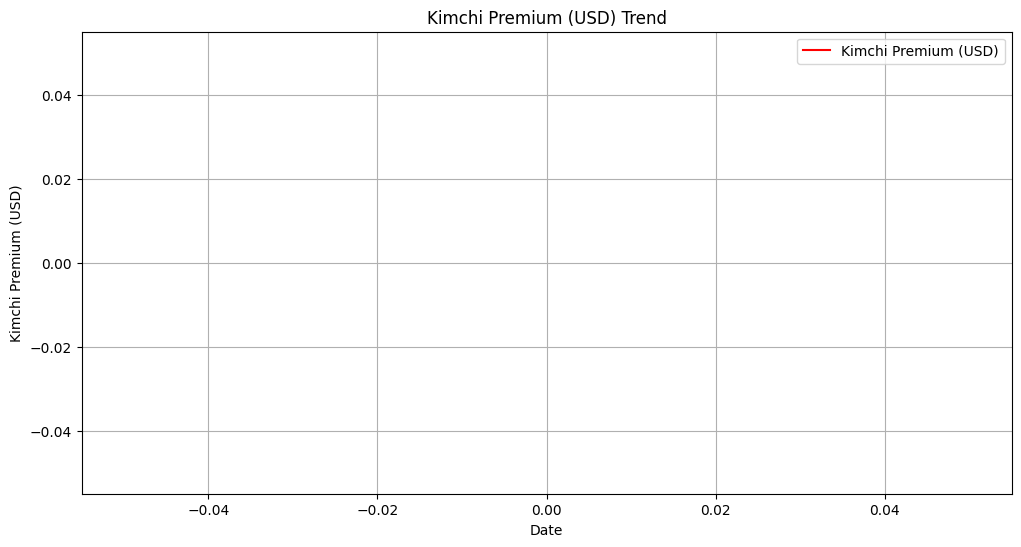

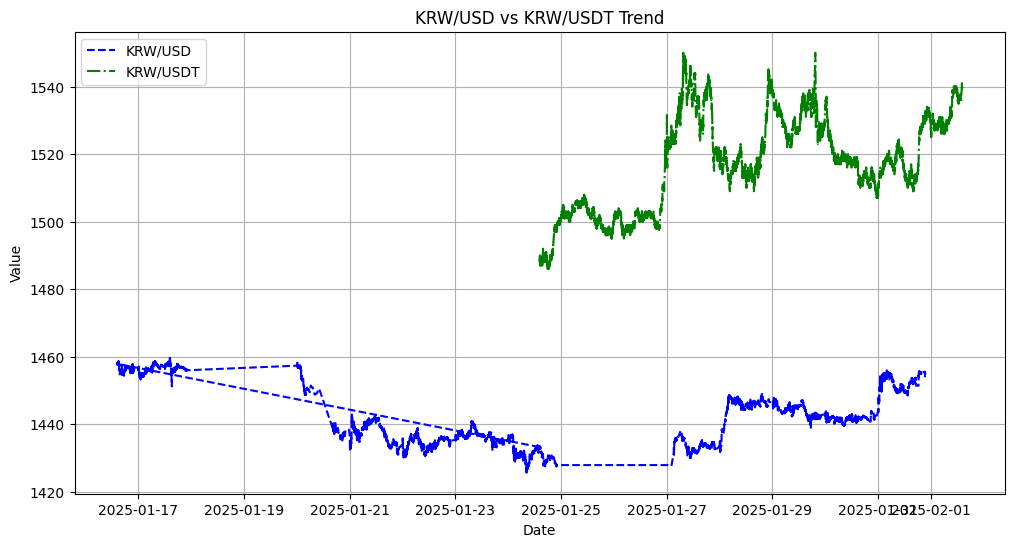

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


conn = sqlite3.connect("derivatives.db")


kpdata = pd.read_sql("SELECT timestamp, kimchi_premium_usd FROM 'BTC'", conn)


krwusddata = pd.read_sql("SELECT timestamp, krw_usd FROM KRWUSD", conn)
krwusdtdata = pd.read_sql("SELECT timestamp, krw_usdt FROM KRWUSDT", conn)



conn.close()


kpdata["timestamp"] = pd.to_datetime(kpdata["timestamp"])
krwusddata["timestamp"] = pd.to_datetime(krwusddata["timestamp"])
krwusdtdata["timestamp"] = pd.to_datetime(krwusdtdata["timestamp"])


kpdata.dropna(inplace=True)
krwusddata.dropna(inplace=True)
krwusdtdata.dropna(inplace=True)
print(kpdata.head())
print(krwusddata.head())
print(krwusdtdata.head())


plt.figure(figsize=(12, 6))
plt.plot(kpdata["timestamp"], kpdata["kimchi_premium_usd"], label="Kimchi Premium (USD)", linestyle="-", color="red")
plt.xlabel("Date")
plt.ylabel("Kimchi Premium (USD)")
plt.title("Kimchi Premium (USD) Trend")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(krwusddata["timestamp"], krwusddata["krw_usd"], label="KRW/USD", linestyle="--", color="blue")
plt.plot(krwusdtdata["timestamp"], krwusdtdata["krw_usdt"], label="KRW/USDT", linestyle="-.", color="green")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("KRW/USD vs KRW/USDT Trend")
plt.legend()
plt.grid()
plt.show()


In [ ]:
!pip install finance-datareader

In [ ]:
import requests
from bs4 import BeautifulSoup

response = requests.get("https://finance.naver.com/marketindex/exchangeList.naver")
soup = BeautifulSoup(response.content, "html.parser")

rows = soup.find_all("tr")

for row in rows:

    columns = row.find_all("td")

    if len(columns) >= 7:

        country = columns[0].text.strip()
        exchange_rate1 = columns[1].text.strip()




        print(country, exchange_rate1)

미국 USD 1,458.30
유럽연합 EUR 1,511.31
일본 JPY (100엔) 939.60
중국 CNY 199.18
홍콩 HKD 187.13
대만 TWD 44.22
영국 GBP 1,807.27
오만 OMR 3,787.79
캐나다 CAD 1,003.85
스위스 CHF 1,600.68
스웨덴 SEK 131.42
호주 AUD 905.90
뉴질랜드 NZD 821.97
체코 CZK 59.96
칠레 CLP 1.49
튀르키예 TRY 40.85
몽골 MNT 0.42
이스라엘 ILS 407.51
덴마크 DKK 202.49
노르웨이 NOK 128.83
사우디아라비아 SAR 388.81
쿠웨이트 KWD 4,725.69
바레인 BHD 3,868.27
아랍에미리트 AED 397.03
요르단 JOD 2,056.84
이집트 EGP 29.03
태국 THB 43.15
싱가포르 SGD 1,073.23
말레이시아 MYR 327.34
인도네시아 IDR 100 8.97
카타르 QAR 399.99
카자흐스탄 KZT 2.81
브루나이 BND 1,073.23
인도 INR 16.85
파키스탄 PKR 5.23
방글라데시 BDT 11.96
필리핀 PHP 24.97
멕시코 MXN 70.51
브라질 BRL 249.64
베트남 VND 100 5.87
남아프리카 공화국 ZAR 78.11
러시아 RUB 14.73
헝가리 HUF 3.71
폴란드 PLN 358.65
스리랑카 LKR 4.89
알제리 DZD 10.78
케냐 KES 11.29
콜롬비아 COP 0.35
탄자니아 TZS 0.57
네팔 NPR 10.52
루마니아 RON 303.71
리비아 LYD 297.03
마카오 MOP 181.58
미얀마 MMK 0.69
에티오피아 ETB 11.40
우즈베키스탄 UZS 0.11
캄보디아 KHR 0.36
피지 FJD 627.80


In [ ]:
import FinanceDataReader as fdr
df = fdr.DataReader('USD/KRW')
print(df)

                   Open         High          Low        Close  Volume  \
2023-09-10  1335.319946  1335.319946  1326.030029  1335.319946     0.0   
2023-09-11  1320.439941  1328.780029  1322.800049  1320.439941     0.0   
2023-09-12  1324.099976  1330.020020  1322.420044  1324.099976     0.0   
2023-09-13  1329.770020  1330.339966  1322.430054  1329.770020     0.0   
2023-09-14  1327.060059  1330.300049  1323.709961  1327.060059     0.0   
...                 ...          ...          ...          ...     ...   
2025-01-27  1427.630005  1438.790039  1427.630005  1427.630005     0.0   
2025-01-28  1417.920044  1450.430054  1407.589966  1417.920044     0.0   
2025-01-29  1443.260010  1448.439941  1422.050049  1443.260010     0.0   
2025-01-30  1443.319946  1444.000000  1438.930054  1443.319946     0.0   
2025-01-31  1441.660034  1455.770020  1444.579956  1441.660034     0.0   

              Adj Close  
2023-09-10  1335.319946  
2023-09-11  1320.439941  
2023-09-12  1324.099976  
2023-09